In [1]:
import requests
%matplotlib inline

In [403]:
import facebook
# Get temporal token from here: https://developers.facebook.com/tools/explorer/
token = ""

graph = facebook.GraphAPI(token)
profile = graph.get_object("me")

In [404]:
profile["name"]

u'Arantxa Romano'

In [405]:
def process(container, post):

    if post.has_key('message'):
        message = post['message']
    else:
        message = None

    likes = []
    if post.has_key('likes'):    
        for like in post['likes']['data']:
            likes.append(like['name'])        

    container.append({'message': message,
              'created_time': post['created_time'],
              'likes': likes})
    
    return container

In [406]:
total_posts = []
container = []
posts = graph.get_connections(profile['id'], 'posts')

total_posts.extend(posts['data'])
count = 0
while count<130:
    if count%1==10: 
        print count
    
    if posts.has_key('data'):
        total_posts.extend(posts['data'])
    else:
        break
    
    try:
        
        total_posts.extend(posts['data'])
        for post in posts['data']:
            container = process(container, post=post)
            
        # Attempt to make a request to the next page of data, if it exists.
        posts = requests.get(posts['paging']['next']).json()    
        count+=1
        
    except KeyError as e:
        # When there are no more pages (['paging']['next']), break from the
        # loop and end the script.
        print "KeyError", e
        break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
KeyError 'paging'


In [408]:
# Store posts in file for further experiments
user = profile["name"]
fname = user + ".txt"
f = open(fname, 'w')
json.dump(total_posts, f)
f.close()

In [409]:
len(container)

2420

In [410]:
container = container[0:2100]

In [411]:
from datetime import datetime

likes_dates = []
for d in container:
    if len(d['likes'])==0:
        likes_dates.append((None, 
                            int(datetime.strptime(d['created_time'], '%Y-%m-%dT%H:%M:%S+%f').strftime('%s'))
                           ))       
    for like in d['likes']:
        likes_dates.append((like, 
                            int(datetime.strptime(d['created_time'], '%Y-%m-%dT%H:%M:%S+%f').strftime('%s'))
                           ))

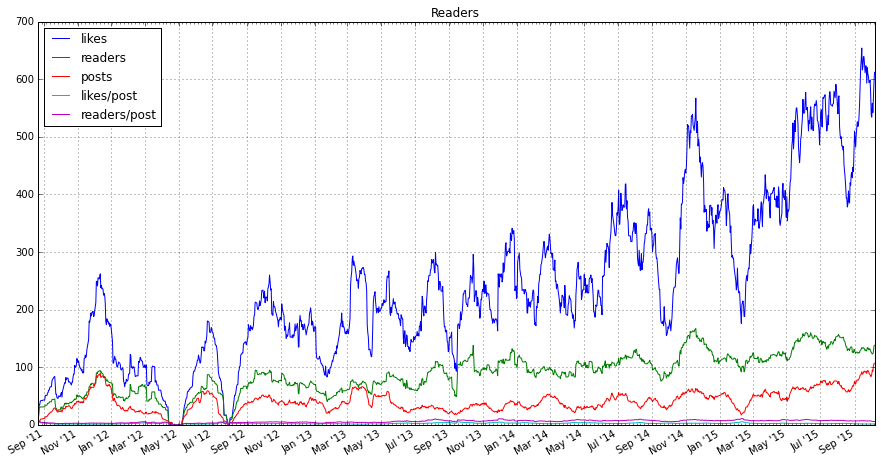

In [431]:
# Compute cumsum (temporal window)
from sets import Set
import numpy as np

NMONTHS = 1

dates = np.array([ld[1] for ld in likes_dates])
steps = np.arange(min(dates),max(dates),3600*24)

window = 3600*24*30*NMONTHS
cumsum_likes = []
cumsum_users = []
cumsum_posts = []
for i in steps:
    #nlikes = sum((dates < i) & (dates > i - window))
    
    mask = (dates < i) & (dates > i - window)
    nlikes = sum(mask)
    nposts = len(set(dates[mask])) # there is a post per timestamp
    nusers = len(set([ld[0] for ld in likes_dates if (ld[1]<i) and (ld[1]>i-window)]))

    cumsum_likes.append(nlikes)
    cumsum_users.append(nusers)
    cumsum_posts.append(nposts)
    
    
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import MONDAY
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
from matplotlib import dates as da

# every monday
mondays = WeekdayLocator(MONDAY)

# every 3rd month
months = MonthLocator(range(1, 14), bymonthday=1, interval=2)
monthsFmt = DateFormatter("%b '%y")

plt.figure(figsize=(20,10)) 
fig, ax = plt.subplots(figsize=(15,8))
ax.plot_date(da.epoch2num(steps), cumsum_likes, '-', label="likes")
ax.plot_date(da.epoch2num(steps), cumsum_users, '-', label="readers")
ax.plot_date(da.epoch2num(steps), cumsum_posts, '-', label="posts")
ax.plot_date(da.epoch2num(steps), np.array(cumsum_users)/(np.array(cumsum_posts)+0.00001), '-', label="likes/post")
ax.plot_date(da.epoch2num(steps), np.array(cumsum_likes)/(np.array(cumsum_posts)+0.00001), '-', label="readers/post")

ax.legend(loc=2)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.xaxis.set_minor_locator(mondays)
ax.autoscale_view()
ax.grid(True)

fig.autofmt_xdate()
plt.title("Readers")
plt.show()

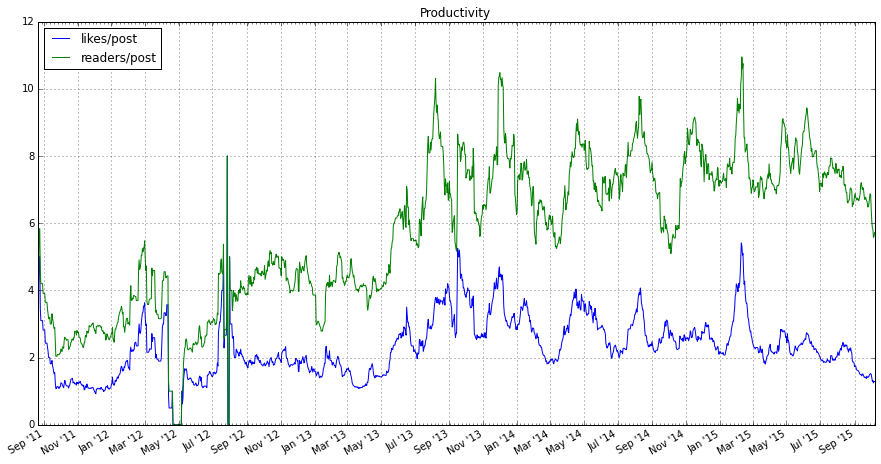

In [433]:
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import MONDAY
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
from matplotlib import dates as da

# every monday
mondays = WeekdayLocator(MONDAY)

# every 3rd month
months = MonthLocator(range(1, 14), bymonthday=1, interval=2)
monthsFmt = DateFormatter("%b '%y")

plt.figure(figsize=(20,10)) 
fig, ax = plt.subplots(figsize=(15,8))
ax.plot_date(da.epoch2num(steps), np.array(cumsum_users)/(np.array(cumsum_posts)+0.00001), '-', label="likes/post")
ax.plot_date(da.epoch2num(steps), np.array(cumsum_likes)/(np.array(cumsum_posts)+0.00001), '-', label="readers/post")

ax.legend(loc=2)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.xaxis.set_minor_locator(mondays)
ax.autoscale_view()
ax.grid(True)

fig.autofmt_xdate()
plt.title("Productivity")
plt.show()

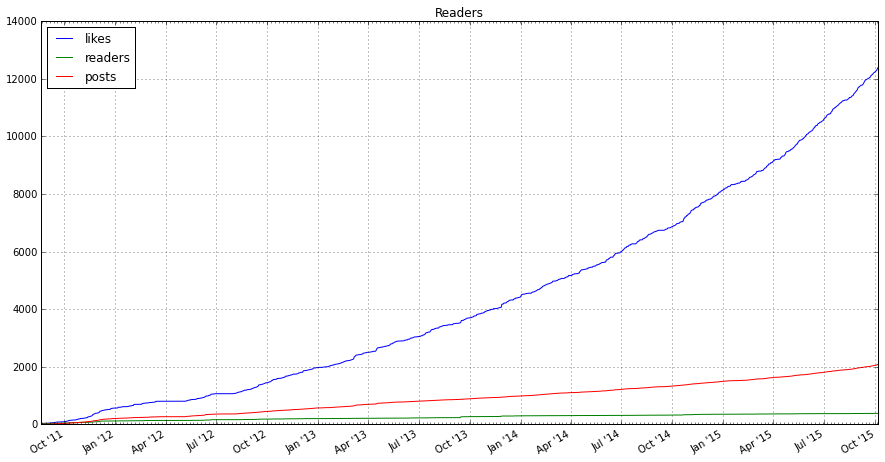

In [435]:
# Compute cumsum (temporal window)
from sets import Set
import numpy as np

NMONTHS = 100

dates = np.array([ld[1] for ld in likes_dates])
steps = np.arange(min(dates),max(dates),3600*24)

window = 3600*24*30*NMONTHS
cumsum_likes = []
cumsum_users = []
cumsum_posts = []
for i in steps:
    #nlikes = sum((dates < i) & (dates > i - window))
    
    mask = (dates < i) & (dates > i - window)
    nlikes = sum(mask)
    nposts = len(set(dates[mask])) # there is a post per timestamp
    nusers = len(set([ld[0] for ld in likes_dates if (ld[1]<i) and (ld[1]>i-window)]))

    cumsum_likes.append(nlikes)
    cumsum_users.append(nusers)
    cumsum_posts.append(nposts)
    
    
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import MONDAY
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
from matplotlib import dates as da

# every monday
mondays = WeekdayLocator(MONDAY)

# every 3rd month
months = MonthLocator(range(1, 14), bymonthday=1, interval=3)
monthsFmt = DateFormatter("%b '%y")

plt.figure(figsize=(20,10)) 
fig, ax = plt.subplots(figsize=(15,8))
ax.plot_date(da.epoch2num(steps), cumsum_likes, '-', label="likes")
ax.plot_date(da.epoch2num(steps), cumsum_users, '-', label="readers")
ax.plot_date(da.epoch2num(steps), cumsum_posts, '-', label="posts")

ax.legend(loc=2)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.xaxis.set_minor_locator(mondays)
ax.autoscale_view()
ax.grid(True)

fig.autofmt_xdate()
plt.title("Readers")
plt.show()